##### 0 data preprocessing and visulization

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

from datetime import datetime, timedelta
from scipy.interpolate import interp1d

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell): return

In [2]:
# load input data files
bonds = pd.read_excel('data/C1Data.xlsx', sheet_name='Bonds', index_col='ISSUE_ID')
bonds.columns = ['transactionDate', 'price', 'maturityDate', 'spread',
       'offeringDate', 'principal', 'interestFrequency', 'couponRate',
       'rating', 'securityLevel']

yield_curve = pd.read_excel('data/C1Data.xlsx', sheet_name='YieldCurve')
yield_curve = yield_curve.iloc[:-1]   #remove the last row
yield_curve['year'] = (yield_curve.index + 1) * 0.25  #index starts from 0 to # rows-1
yield_curve = yield_curve.set_index('year')
yield_curve = yield_curve.drop(columns='Date')
yield_curve.columns = ['2024-05-31', '2025-01-13']  #change col names
yield_curve = yield_curve.astype({'2025-01-13': 'float64'})  #convert data type

In [3]:
# get US yield curve
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2024

yield_us = pd.read_csv('data/daily-treasury-rates.csv')
yield_us = yield_us[yield_us.Date=='05/31/2024']  # select the same date as bonds were traded
yield_us = yield_us.iloc[:, 1:] 
yield_us.columns = [1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
yield_us = yield_us.transpose()

/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_13007/1695665613.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=20)


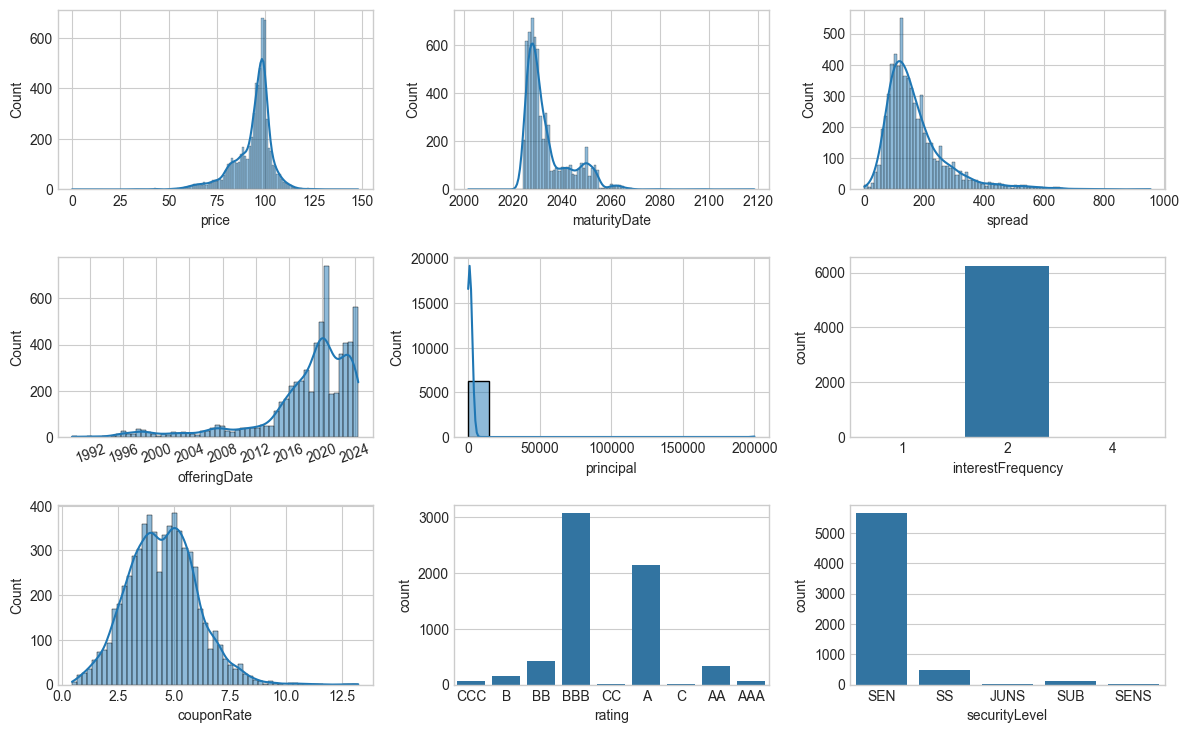

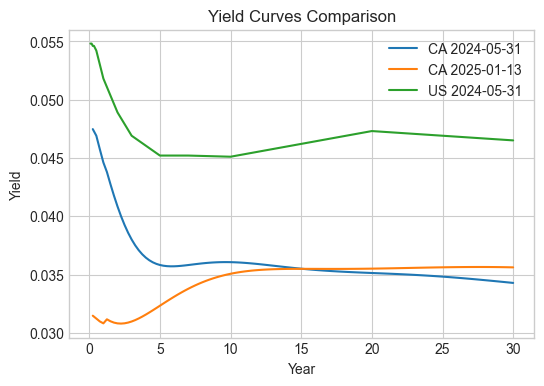

In [4]:
# plot variables in 'bonds' 
categorical_cols = ['interestFrequency', 'rating', 'securityLevel']
numeric_cols = [i for i in bonds.columns if i not in categorical_cols]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))
for i, column in enumerate(bonds.columns[1:]):
    if column in categorical_cols:
        sns.countplot(data=bonds, x=column, ax=axes[i//3, i%3])  #row, column
    else:
        sns.histplot(data=bonds, x=column, kde=True, ax=axes[i//3, i%3])

    # rotate ticks
    if column in ['offeringDate']:
        axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=20)

for j in range(i + 1, 15):
    fig.delaxes(axes[j//3, j%3])  #delete empty subplots
plt.tight_layout()
plt.show()

# plot yield curve
plt.figure(figsize=(6,4))
plt.plot(yield_curve.index, yield_curve['2024-05-31'], label='CA 2024-05-31')
plt.plot(yield_curve.index, yield_curve['2025-01-13'], label='CA 2025-01-13')
plt.plot(yield_us.index, yield_us/100, label='US 2024-05-31')
plt.xlabel('Year')
plt.ylabel('Yield')
plt.legend()
plt.title("Yield Curves Comparison");

In [5]:
bonds.head(n=3)

,transactionDate,price,maturityDate,spread,offeringDate,principal,interestFrequency,couponRate,rating,securityLevel
ISSUE_ID,,,,,,,,,,
1080888,2024-05-31,108.867,2028-12-31,954.0,2023-04-25,1000,2,12.75,CCC,SEN
840849,2024-05-31,103.375,2027-08-01,952.0,2019-07-31,1000,2,10.75,CCC,SEN
853359,2024-05-31,100.140,2025-04-15,940.0,2019-09-27,1000,2,11.00,CCC,SEN


In [6]:
yield_curve.head()

,2024-05-31,2025-01-13
year,,
0.25,0.047468,0.031470
0.50,0.046900,0.031224
0.75,0.045734,0.030977
1.00,0.044603,0.030813
1.25,0.043789,0.031161


##### Question 1 & 2: bond pricing using different yield curves

according to the bond pricing formula, we need to know 
1) coupon. Which is couponRate / interestFrequency $\times$ principal; <br>
2) coupon payment schedule. Use the bond **offering date** and the payment frequency to get the dates of cash flows.  For some bonds this makes the last coupon happen before the maturity, which is fine. Also note the maturity date marks the return of principal, which doesn’t necessarily coincide with the last coupon date. For example, if a bond was issued on January 1, 2020 with semiannual coupons, the fixed coupon dates would be January 1 and July 1 each year. If it matures on March 15, 2025, the final full coupon would have been paid on January 1, 2025, and the investor would receive accrued interest from that date until maturity, along with the principal. Not: generate a list of dates from matrurity date to transaction date according to payment frequency, then reverse the list. <br>
3) risk free rate: we are required to use Canadian risk free rate on the transaction date (05-31-2024); <br>
4) spread, which is the spread column of the Bonds sheet

Coupon amount

In [7]:
# amount per payment
bonds['coupon'] = bonds.couponRate/100 * bonds.principal / bonds.interestFrequency

Coupon payment

In [8]:
def count_remaining_coupons(df):
    ''' Compute coupon dates, number of coupons, and accrued interest '''
    
    # generate all coupon payment dates
    coupon_dates = []
    delta = 12 // df.interestFrequency
    start = df.offeringDate + pd.DateOffset(months=delta)
    
    while start < df.maturityDate:
        coupon_dates.append(start) 
        start = start + pd.DateOffset(months=delta)
    
    accrual_period = (df.maturityDate - coupon_dates[-1]).days
    accrued_interest = accrual_period * (df.couponRate/(100*365)) * df.principal  # assumes actual/actual convention

    coupon_dates = pd.Series(coupon_dates) # convert to Series for filtering
    coupon_dates = coupon_dates[coupon_dates > df.transactionDate].tolist()
    numCoupons = len(coupon_dates)

    return pd.Series([coupon_dates, numCoupons, accrued_interest])

bonds[['coupon_dates', 'numCoupons', 'accrued_interest']] = bonds.apply(count_remaining_coupons, axis=1)

In [9]:
bonds[['transactionDate', 'maturityDate', 'offeringDate', 'interestFrequency', 'coupon_dates', 'accrued_interest']].head()

,transactionDate,maturityDate,offeringDate,interestFrequency,coupon_dates,accrued_interest
ISSUE_ID,,,,,,
1080888,2024-05-31,2028-12-31,2023-04-25,2,"[2024-10-25 00:00:00, 2025-04-25 00:00:00, 202...",23.404110
840849,2024-05-31,2027-08-01,2019-07-31,2,"[2024-07-31 00:00:00, 2025-01-31 00:00:00, 202...",0.294521
853359,2024-05-31,2025-04-15,2019-09-27,2,"[2024-09-27 00:00:00, 2025-03-27 00:00:00]",5.726027
920565,2024-05-31,2027-08-01,2020-07-23,2,"[2024-07-23 00:00:00, 2025-01-23 00:00:00, 202...",2.404110
903365,2024-05-31,2025-05-31,2020-05-13,2,"[2024-11-13 00:00:00, 2025-05-13 00:00:00]",4.684932


Interpolate the risk-free rate

In [51]:
# use 'quadratic' because when using 'cubic' some interpolated interest rates are negative 
def interploate_yield(date):
    interpolate_func = interp1d(
        yield_curve.index,
        yield_curve[date],
        fill_value="extrapolate", 
        kind='quadratic')
    return interpolate_func 

def get_rf(df):
    ''' Return risk-free rate and exponents in the pricing formula'''
    # rf: interpolated risk free rates
    cashflow_dates = pd.Series(df.coupon_dates + [df.maturityDate])
    today = df.transactionDate
    delta = (cashflow_dates - today).dt.days / 365  # express the date difference in year 
    rf = interpolate_func(delta)

    # t: exponents in the pricing formula
    t = (cashflow_dates - today).dt.days / (365/df.interestFrequency) if len(cashflow_dates)>0 else 0
    
    return pd.Series([rf, t, cashflow_dates])

interpolate_func = interploate_yield('2024-05-31')
bonds[['rf', 't', 'cf_dates']] = bonds.apply(get_rf, axis=1)    

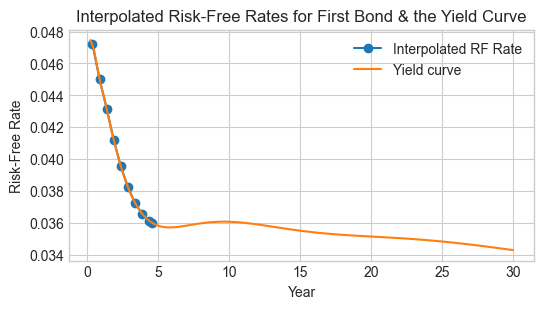

In [11]:
# visualize the interpolated risk-free rates for the first bond

# extract the first bond's rf & t 
rf = bonds.iloc[0].rf
t = bonds.iloc[0].t

# t's unit is period (here 0.5 year as the payment frequency is 2)
# convert period to the year unit for plotting
year = t * 0.5

plt.figure(figsize=(6,3))
plt.plot(year, rf, marker='o', label="Interpolated RF Rate")
plt.plot(yield_curve.index, yield_curve['2024-05-31'], label='Yield curve')
plt.xlabel("Year"), plt.ylabel("Risk-Free Rate")
plt.legend()
plt.title("Interpolated Risk-Free Rates for First Bond & the Yield Curve")
plt.show()


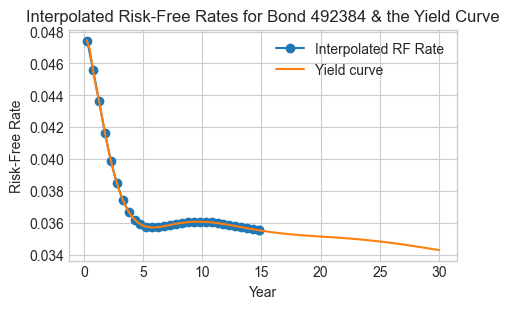

In [20]:
# another bond 
issue_id= 492384

rf = bonds.loc[issue_id].rf
t = bonds.loc[issue_id].t

year = t * 0.5

plt.figure(figsize=(5, 3))
plt.plot(year, rf, marker='o', label="Interpolated RF Rate")
plt.plot(yield_curve.index, yield_curve['2024-05-31'], label='Yield curve')
plt.xlabel("Year"), plt.ylabel("Risk-Free Rate")
plt.title(f"Interpolated Risk-Free Rates for Bond {issue_id} & the Yield Curve")
plt.legend()
plt.show()

Discount the cashflows

In [ ]:
def generate_cashflows(df):
    cashflows = np.repeat(df.coupon, df.numCoupons)
    cashflows = np.append(cashflows, df.principal + df.accrued_interest)
    return cashflows

bonds['cashflows'] = bonds.apply(generate_cashflows, axis=1)

In [ ]:
def discount_cf(df, rf='rf'):    
    # 1. cashflows
    cashflows = df.cashflows
    # 2. exponents indicating time
    ts = df.t   
    # 3. rates, sum the rf and spread, both annulized
    rates = df[rf] + df.spread/10000    # basis points conversion

    # r/df.interestFrequency: adjust annulized rates to period-wise rates
    discounted_cf = [cashflow / (1 + rate/df.interestFrequency)**t
                     for cashflow, rate, t in zip(cashflows, rates, ts)]
    
    return sum(discounted_cf) / df.principal * 100  # express price as a % of the principal

# remove where maturityDate < transactionDate, 1 row
bonds = bonds.loc[bonds.maturityDate >= bonds.transactionDate]
bonds['price2'] = bonds.apply(discount_cf, axis=1)

In [15]:
bonds[['price', 'price2']].head()

,price,price2
ISSUE_ID,,
1080888,108.867,99.650523
840849,103.375,97.014158
853359,100.140,99.601673
920565,103.116,94.905531
903365,100.250,96.715547


Compare the two prices 

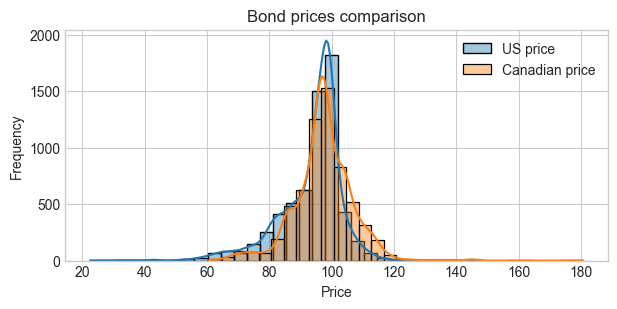

In [48]:
# histplot
plt.figure(figsize=(7, 3))
sns.histplot(bonds.price, bins = 30, kde=True, alpha=0.4, label='US price',edgecolor='black')
sns.histplot(bonds.price2, bins = 30, kde=True, alpha=0.4, label='Canadian price', edgecolor='black')
plt.xlabel('Price'), plt.ylabel('Frequency')
plt.title('Bond prices comparison')
plt.legend()
plt.show()

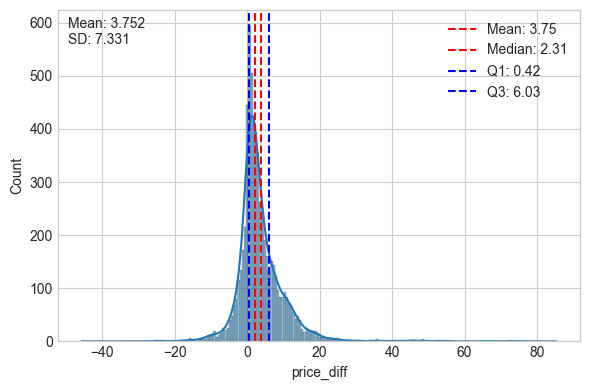

0.804 - proportion of bonds priced higher


In [46]:
# show the distribution of the price difference
def plot_distribution_with_stats(data, figsize=(6, 4)):
    ''' Plot distribution with mean, percentiles, and standard deviation annotated '''
    # Calculate statistics
    mean_val = data.mean()
    std_val = data.std()
    q25, q50, q75 = data.quantile([0.25, 0.5, 0.75])
    
    # Create plot
    plt.figure(figsize=figsize)
    sns.histplot(data, kde=True)
    
    # Add vertical lines
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(q50, color='red', linestyle='--', label=f'Median: {q50:.2f}')
    plt.axvline(q25, color='blue', linestyle='--', label=f'Q1: {q25:.2f}')
    plt.axvline(q75, color='blue', linestyle='--', label=f'Q3: {q75:.2f}')
    
    # Add statistics text
    plt.text(0.02, 0.98, f'Mean: {mean_val:.3f}\nSD: {std_val:.3f}', 
             transform=plt.gca().transAxes, verticalalignment='top')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

bonds['price_diff'] = bonds['price2'] - bonds['price']
plot_distribution_with_stats(bonds.price_diff)

print(round(np.mean(bonds.price_diff > 0), 3), '- proportion of bonds priced higher')

In [25]:
# bonds that were instead priced lower - due to maturity date?
bonds[bonds.price_diff <= 0]['maturityDate'].describe()

count                             1230
mean     2031-04-11 13:17:16.097561088
min                2024-08-15 00:00:00
25%                2026-06-01 00:00:00
50%                2028-12-05 00:00:00
75%                2031-02-15 00:00:00
max                2115-09-15 00:00:00
Name: maturityDate, dtype: object

In [49]:
# due to coupon rate?
print(round(pd.concat([bonds[bonds.price_diff <= 0]['couponRate'].describe(), bonds.couponRate.describe()], axis=1)),3)
print('Correlation between coupon rate and price difference:', round(bonds.couponRate.corr(bonds.price_diff),3))

       couponRate  couponRate
count      1230.0      6261.0
mean          5.0         4.0
std           2.0         2.0
min           1.0         0.0
25%           4.0         3.0
50%           5.0         4.0
75%           6.0         6.0
max          13.0        13.0 3
Correlation between coupon rate and price difference: 0.09


In [35]:
# due to spread?
print(round(pd.concat([bonds[bonds.price_diff <= 0]['spread'].describe(), bonds.spread.describe()], axis=1)),3)
print('Correlation between spread and price difference:', round(bonds.spread.corr(bonds.price_diff),3))

       spread  spread
count  1230.0  6261.0
mean    302.0   173.0
std     139.0   109.0
min      45.0     0.0
25%     210.0   105.0
50%     270.0   145.0
75%     354.0   205.0
max     954.0   954.0 3
Correlation between spread and price difference: -0.307


In [45]:
# Multiple regression to isolate effects
from sklearn.linear_model import LinearRegression
X = bonds[['spread', 'couponRate']]
X['time_to_maturity'] = (bonds.maturityDate - bonds.transactionDate).dt.days
y = bonds['price_diff']
model = LinearRegression().fit(X, y)
print("Coefficients:", dict(zip(X.columns, model.coef_)))
print("R-squared:", model.score(X, y))

Coefficients: {'spread': -0.02619025516614088, 'couponRate': 0.9866757981951908, 'time_to_maturity': 0.0008407305042191352}
R-squared: 0.3157427145828908


/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_13007/3995334766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['time_to_maturity'] = (bonds.maturityDate - bonds.transactionDate).dt.days


A US bond may have a fair value of 100 but trades at 102 (*price* column in the dataset). Using the CA yield curve which is lower than the US one, we would get a Canadian fair value of 101 > 100 but < 102. Market microstructure effects such as supply and demand, liquidity, and market players, would have an impact.

Calculate the price on Jan 13, 2025, & compare three prices

In [52]:
# re-calculate rf
interpolate_func = interploate_yield('2025-01-13')
bonds[['rf_0113', 't', 'cf_dates']] = bonds.apply(get_rf, axis=1)  

# re-compute the price
bonds['price_0113'] = bonds.apply(lambda df: discount_cf(df, rf='rf_0113'), axis=1)

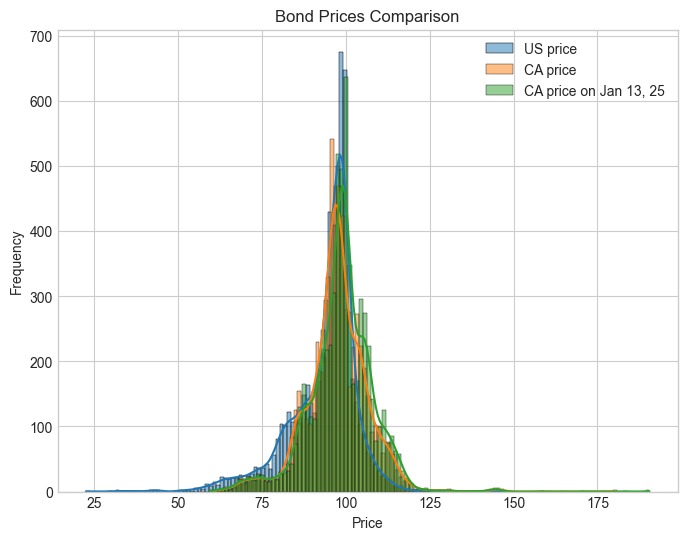

In [68]:
# compare three prices. histplot
plt.figure(figsize=(8, 6))
sns.histplot(bonds.price, alpha=0.5, kde=True, label='US price')
sns.histplot(bonds.price2, alpha=0.5, kde=True, label='CA price', color='#ff7f0e')
sns.histplot(bonds.price_0113, alpha=0.5, kde=True, label='CA price on Jan 13, 25', color='#2ca02c')

plt.xlabel('Price'), plt.ylabel('Frequency')
plt.title('Bond Prices Comparison')
plt.legend()
plt.show()

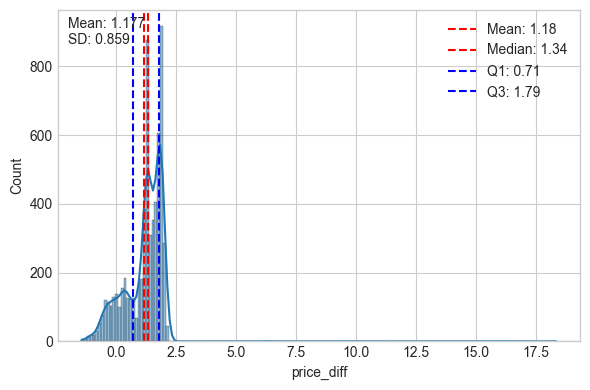

0.884 - proportion of bonds priced higher


In [66]:
# numeric
bonds['price_diff'] = bonds['price_0113'] - bonds['price2']
plot_distribution_with_stats(bonds.price_diff)

print(round(np.mean(bonds.price_diff>0), 3), '- proportion of bonds priced higher')

##### Question 3: calculate the capital requirements of these bonds

Compute LGD and EAD

In [ ]:
# according to 5.4.1 (ii), OSFI guideline
# LGD of SS (Senior Secured) should still > 0
level_to_LGD = {
    'JUN':0.75, 'JUNS':0.75, 'SEN':0.4, 'SENS':0.75,
    'SS':0.2, 'SUB':0.75
}

In [70]:
def calculate_EAD(df, price='price'):
    ''' args: price: 'price', 'price2', or 'price_0113 '''
    EAD = df[price] / 100 * df.principal
    return EAD

bonds['EAD'] = bonds.apply(lambda df: calculate_EAD(df, 'price'), axis=1)

In [72]:
bonds.EAD.head()

ISSUE_ID
1080888    1088.67
840849     1033.75
853359     1001.40
920565     1031.16
903365     1002.50
Name: EAD, dtype: float64

PD

PD = X ~ lognormal(mu, sigma^2) <br>
*mu_x*: E(PD) = exp(mu + 1/2 * sigma^2) <br>
Var(PD) = (exp(sigma^2) - 1) * exp(2*mu + sigma^2) <br>
*sigma_x*: SD(PD) <br>
*mu_x* and *sigma_x* are known from the table, need to compute mu and sigma^2 such that *mu_x* and *sigma_x* match the known values

In [73]:
# rating: (weighted long-term average, standard deviation)
# these values correspond to the table and they are expressed as percentages
rating_default_rate = {'AAA':(0,0), 'AA':(0.02, 0.06), 'A':(0.05,0.1),
                  'BBB':(0.14,0.25), 'BB':(0.57,0.96), 'B':(2.98,3.23),
                  'CCC':(25.98,11.73), 'CC':(25.98,11.73), 'C':(25.98,11.73)}

num_sim = 10000
rng = np.random.default_rng(1)
z_values = rng.standard_normal(num_sim)

# row is each realization, columns are ratings
PD_sim = pd.DataFrame(index=range(num_sim),
                      columns=list(rating_default_rate.keys()),
                      dtype=float)

# for AAA bond, treat its PD as a constant==0
PD_sim['AAA'] = 0 

for col in PD_sim.columns[1:]:  
    mu_x, sigma_x = rating_default_rate[col] 
    mu_x, sigma_x  = mu_x / 100, sigma_x / 100
    mu = np.log(mu_x**2 / np.sqrt(mu_x**2 + sigma_x**2))
    sigma2 = np.log(1 + sigma_x**2/mu_x**2)
    sigma = np.sqrt(sigma2)
    PD_sim[col] = np.exp(mu + sigma * z_values)

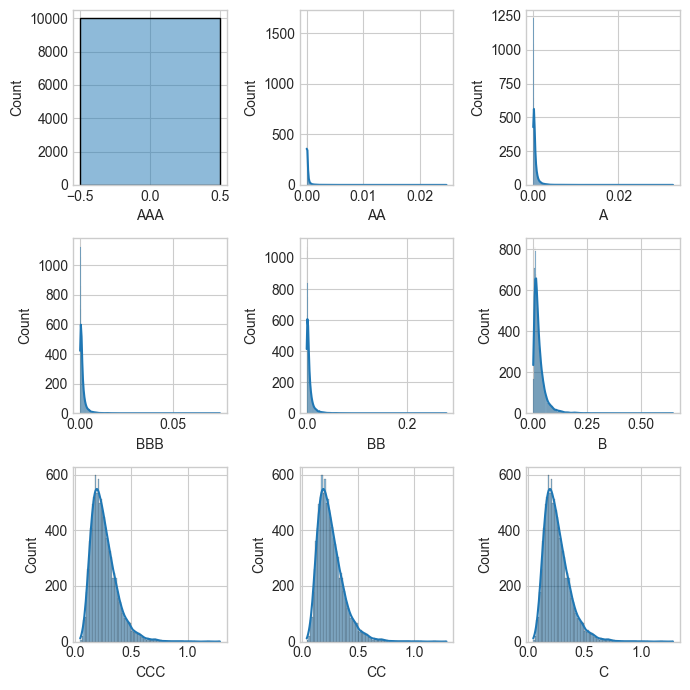

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 7))
for i, column in enumerate(PD_sim.columns):
        sns.histplot(data=PD_sim, x=column, kde=True, ax=axes[i//3, i%3]) 
plt.tight_layout()
plt.show()

In [75]:
# trim the PD values that are greater than 1
PD_sim[PD_sim >1] = 1
PD_sim[PD_sim < 0.0005] = 0.0005   # PD floor for corporate exposure 

/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_13007/1094114626.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  PD_sim[PD_sim < 0.0005] = 0.0005


In [77]:
PD_sim.head()

,AAA,AA,A,BBB,BB,B,CCC,CC,C
0,0.0005,0.0005,0.000500,0.001034,0.004344,0.027403,0.274788,0.274788,0.274788
1,0.0005,0.0005,0.000634,0.001829,0.007545,0.041689,0.337324,0.337324,0.337324
2,0.0005,0.0005,0.000500,0.001016,0.004269,0.027039,0.273001,0.273001,0.273001
3,0.0005,0.0005,0.000500,0.000500,0.000642,0.006407,0.135076,0.135076,0.135076
4,0.0005,0.0005,0.000705,0.002021,0.008314,0.044883,0.349713,0.349713,0.349713


Effective maturity M

In [ ]:
# compute the effective maturity for the bonds
# according to 5.4.1 (iv) 133, OSFI guideline
def get_maturity(df):
    ''' Compute the effective maturity '''
    m = np.sum(df.t * df.cashflows) / np.sum(df.cashflows)
    if m < 1: m = 1
    if m > 5: m = 5
    return m

bonds['maturity'] = bonds.apply(get_maturity, axis=1)

$$
K = LGD \cdot \left\{ N\left( \sqrt{\frac{1}{1-R}} \cdot N^{-1}(PD) + \sqrt{\frac{R}{1-R}} \cdot N^{-1}(0.999) \right) - PD \right\} \left( \frac{1 + (M - 2.5)b}{1 - 1.5b}\right)
$$

Corporate and sovereign exposures $ R = 0.12 \left( \frac{1 - e^{-50PD}}{1 - e^{-50}} \right) + 0.24 \left( 1 - \frac{1 - e^{-50PD}}{1 - e^{-50}} \right)$

Effective maturity $M$ = cashflow-weighted average of periods

Maturity adjustment $b = (0.11852-0.05478 \cdot ln(PD))^2$

Full maturity adjustment: $\frac{1 + (M - 2.5)b}{1 - 1.5b}$

In [78]:
def cal_capital_requirement(df):
    from scipy.stats import norm

    rating= df.rating
    PD = PD_sim[rating]  # a list of simuated PD values with mean and SD correpsonding to that rating
    
    b = (0.11852 - 0.05478 * np.log(PD))**2
    maturity = df.maturity
    adjustment = (1+(maturity-2.5)*b) / (1-1.5*b)
    
    LGD = level_to_LGD.get(df.securityLevel)
    
    R = 0.12 * ((1 - np.exp(-50*PD)) / (1 - np.exp(-50)))  \
        + 0.24 * (1 - ((1 - np.exp(-50*PD)) / (1 - np.exp(-50))))    
    
    # ppf is inverse of cdf
    x = np.sqrt(1/(1 - R)) * norm.ppf(PD) + np.sqrt(R/(1 - R)) * norm.ppf(0.999)
    PD_downturn = norm.cdf(x)
    K = (PD_downturn - PD) * LGD * adjustment
    reg_cap = K * df.EAD 
    return reg_cap

In [87]:
def cal_provision(df):
    rating= df.rating
    PD = PD_sim[rating]
    LGD = level_to_LGD.get(df.securityLevel)  
    K = PD * LGD   # no adjustment here
    provision = K * df.EAD
    return provision

Calculate the capital requirement & provision for each bond

In [80]:
reg_cap_for_each_bond = bonds.apply(cal_capital_requirement, axis=1)

In [88]:
provision_for_each_bond = bonds.apply(cal_provision, axis=1)

Calculate the capital requirement & the provision for the portfolio, by summing up the required capital/provisions of individual bonds.

In [82]:
reg_cap_for_portfolio = reg_cap_for_each_bond.apply(sum, axis=0)

In [83]:
provision_for_portfolio = provision_for_each_bond.apply(sum, axis=0)

##### Question 3 d & e 
Histogram, descriptive statistics,  discussion about the behaviors of the portfolio, and conclusion from the analyses

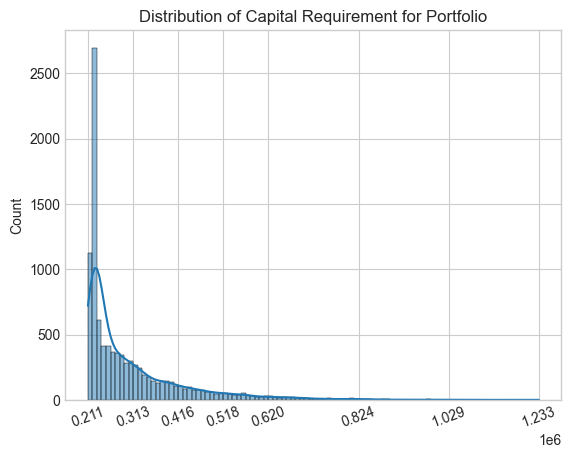

In [84]:
sns.histplot(data = reg_cap_for_portfolio, kde=True)

min_val = reg_cap_for_portfolio.min()
max_val = reg_cap_for_portfolio.max()
val_range = max_val - min_val
ticks1 = np.linspace(min_val, min_val + val_range*0.3, num=4)
ticks2 = np.linspace(min_val + val_range*0.4, max_val, num=4)
xticks = np.concatenate((ticks1, ticks2))
plt.xticks(xticks, rotation=20) 

plt.title("Distribution of Capital Requirement for Portfolio")
plt.show()

In [90]:
# : Starts the formatting specification
# , Adds a thousands separator
# .2f Rounds the number to 2 decimal places
def cal_stats(df):
    from scipy.stats import skew, kurtosis
    stats_basic = df.describe()
    stats_extra = pd.Series({
        'skewness': skew(df),
        'kurtosis': kurtosis(df)
    })
    stats = pd.concat([stats_basic, stats_extra])
    stats['lb_95'] = df.mean() - 1.96 * df.std(ddof=1) / np.sqrt(len(df))
    stats['ub_95'] = df.mean() + 1.96 * df.std(ddof=1) / np.sqrt(len(df))    
    return stats

reg_cap_stats = cal_stats(reg_cap_for_portfolio)
print(reg_cap_stats.apply(lambda x: f'{x:,.2f}'))

count          10,000.00
mean          304,803.23
std           117,154.99
min           211,222.32
25%           227,222.94
50%           255,996.24
75%           338,371.70
max         1,233,046.34
skewness            2.22
kurtosis            6.21
lb_95         302,506.99
ub_95         307,099.47
dtype: object


In [97]:
bonds_ead = bonds.EAD.sum()
print(f'{bonds_ead:,.2f} - EAD')
print(reg_cap_stats.loc['mean']/bonds_ead, ': proportion of the average capital requirement')
print((reg_cap_stats.loc['lb_95']/ bonds_ead, reg_cap_stats['ub_95']/bonds_ead), '- proportion of the capital requirement bounds')

9,417,961.50 - EAD
0.03236403467982251 : proportion of the average capital requirement
(0.03212021994936041, 0.03260784941028462) - proportion of the capital requirement bounds


From the table, we can see that skewness is 2.22 which is greater than 0, i.e., positively skewed. This means most values are concentrated on the left with a few larger values on the right. Kurtosis is greater than 3, which means the distribution has a heavier tail than a normal distribution.

Out of 10,000 simulations, on average, regulatory capital required was US$304,803.23, accounting for 3.24% of the total exposure of the portfolio (EAD was US$9,417,961.51). The 95% confidence interval for the regulatory capital was [302,506.99, 307,099.47]. Dividing these two quantities by EAD and multiplying by 100, we got (3.21, 3.26): for $100 exposure to a portfolio of bonds, the bank needs to set aside $3.21 ~ $3.26 as economic capital


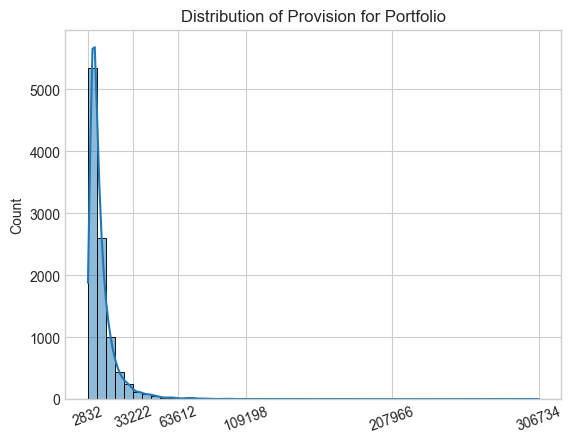

In [98]:
sns.histplot(data=provision_for_portfolio, kde=True, bins=50)

min_val = provision_for_portfolio.min()
max_val = provision_for_portfolio.max()
val_range = max_val - min_val
ticks1 = np.linspace(min_val, min_val + val_range*0.2, num=3)
ticks2 = np.linspace(min_val + val_range*0.35, max_val, num=3)
xticks = np.concatenate((ticks1, ticks2))
plt.xticks(xticks, rotation=20) 

plt.title("Distribution of Provision for Portfolio")
plt.show()

In [99]:
provision_stats = cal_stats(provision_for_portfolio)
print(provision_stats.apply(lambda x: f'{x:,.2f}'))

count        10,000.00
mean         11,896.39
std          11,984.69
min           2,831.82
25%           6,152.84
50%           8,446.06
75%          13,345.85
max         306,734.34
skewness          7.36
kurtosis        103.78
lb_95        11,661.49
ub_95        12,131.29
dtype: object


In [100]:
print(f'{bonds_ead:,.2f} - EAD')
print(provision_stats.loc['mean'] / bonds_ead, '- proportion of the average provision')
print((provision_stats.loc['lb_95']/ bonds_ead, provision_stats['ub_95']/bonds_ead), '- proportion of provision bounds')

9,417,961.50 - EAD
0.0012631592559590773 - proportion of the average provision
(0.0012382175676000147, 0.00128810094431814) - proportion of provision bounds


The provision is also positively skewed; most values are concentrated on the left with a few larger values on the right. Kurtosis is much greater than 3. This means extreme values in the tails are more likely than in a normal distribution.

Out of 10,000 simulations, on average, provision required was US$11,896.39, accounting for 0.13% of total exposure. The 95% confidence interval for the provision was [11,661.49, 12,131.29]. Dividing these two quantities by EAD and multiplying by 100, we got (0.1238, 0.1288). This means for $100 exposure to a portfolio of bonds, the bank needs to set aside $0.123 ~ $0.129 as provision.


##### More analysis
We now analyze the contribution to regulatory capital by bonds of different ratings, which affect PD.

In [131]:
# compute the mean cap. req. for each bond
mean_regcap_for_each_bond = pd.DataFrame({
    'mean_regcap': reg_cap_for_each_bond.apply(np.nanmean, axis=1),
    'rating': bonds.rating})
mean_regcap_for_each_bond.head()

,mean_regcap,rating
ISSUE_ID,,
1080888,198.390078,CCC
840849,188.381919,CCC
853359,160.823213,CCC
920565,108.955213,B
903365,79.229755,B


In [132]:
# group cap. req. by rating
df_grouped = mean_regcap_for_each_bond.groupby('rating')['mean_regcap'].agg(['sum', 'count'])
df_grouped.columns = ['mean_regcap_sum', 'num_bonds']
df_grouped.head()

,mean_regcap_sum,num_bonds
rating,,
A,78040.724983,2152
AA,6774.512491,330
AAA,1171.551352,57
B,12421.549007,153
BB,21788.899399,426


In [133]:
# group EAD by rating
bonds.groupby('rating')['EAD'].sum()

rating
A      3.199972e+06
AA     3.006053e+05
AAA    5.205224e+04
B      1.410923e+05
BB     4.057554e+05
BBB    5.263139e+06
C      1.401560e+03
CC     3.000000e+02
CCC    5.364360e+04
Name: EAD, dtype: float64

In [134]:
# join group-wise cap. req. with group-wise EAD
df_grouped = df_grouped.join(bonds.groupby('rating')['EAD'].sum(), on ='rating')
df_grouped

,mean_regcap_sum,num_bonds,EAD
rating,,,
A,78040.724983,2152,3.199972e+06
AA,6774.512491,330,3.006053e+05
AAA,1171.551352,57,5.205224e+04
B,12421.549007,153,1.410923e+05
BB,21788.899399,426,4.057554e+05
BBB,175438.463435,3069,5.263139e+06
C,234.963961,3,1.401560e+03
CC,54.669481,1,3.000000e+02
CCC,8877.898615,70,5.364360e+04


In [135]:
# compute the proportion of reg. cap. to EAD
df_grouped['regcap/EAD'] = df_grouped.mean_regcap_sum / df_grouped.EAD 
df_grouped

,mean_regcap_sum,num_bonds,EAD,regcap/EAD
rating,,,,
A,78040.724983,2152,3.199972e+06,0.024388
AA,6774.512491,330,3.006053e+05,0.022536
AAA,1171.551352,57,5.205224e+04,0.022507
B,12421.549007,153,1.410923e+05,0.088038
BB,21788.899399,426,4.057554e+05,0.053700
BBB,175438.463435,3069,5.263139e+06,0.033333
C,234.963961,3,1.401560e+03,0.167645
CC,54.669481,1,3.000000e+02,0.182232
CCC,8877.898615,70,5.364360e+04,0.165498


In [136]:
# compute the total values of the columns
df_grouped.loc[len(df_grouped)] = df_grouped.sum()
df_grouped.round(2)

,mean_regcap_sum,num_bonds,EAD,regcap/EAD
rating,,,,
A,78040.72,2152.0,3199972.07,0.02
AA,6774.51,330.0,300605.31,0.02
AAA,1171.55,57.0,52052.24,0.02
B,12421.55,153.0,141092.29,0.09
BB,21788.90,426.0,405755.40,0.05
BBB,175438.46,3069.0,5263139.04,0.03
C,234.96,3.0,1401.56,0.17
CC,54.67,1.0,300.00,0.18
CCC,8877.90,70.0,53643.60,0.17


/var/folders/33/qv3yf4892xld1btchk4myrjc0000gn/T/ipykernel_13007/735450701.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='regcap/EAD', data=df_grouped.iloc[:-1], palette="viridis")


<Axes: xlabel='rating', ylabel='regcap/EAD'>

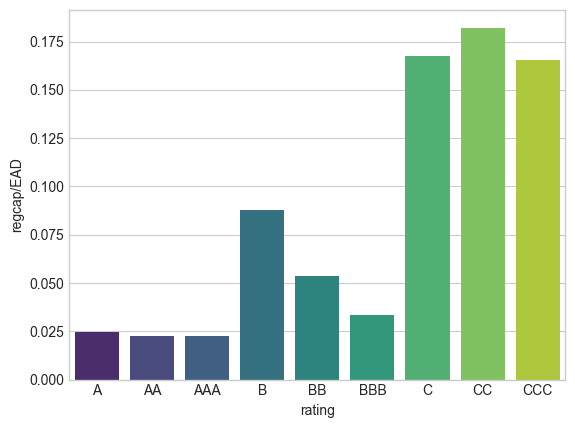

In [142]:
sns.barplot(x='rating', y='regcap/EAD', data=df_grouped.iloc[:-1], palette="viridis")